# Instalação e Carregamento de Todos os Pacotes

In [1]:
!pip install sklearn
!pip install matplotlib
!pip install seaborn

In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
import plotly as py
import plotly.graph_objs as pgo
import pandas as pd
import numpy as np
import seaborn as sns

# Organização dos dados

In [88]:
#leitura dos dados
mcdonalds = pd.read_csv('MCDONALDS.csv', sep=';', header= 0, decimal=',')
#substituindo e deletando os indice pela primeira coluna
mcdonalds = mcdonalds.set_index('Lanche')

In [89]:
mcdonalds.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, Big Mac to CBO 
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Valor Energetico    25 non-null     int64  
 1   Carboidratos        25 non-null     int64  
 2   Proteinas           25 non-null     int64  
 3   Gorduras Totais     25 non-null     float64
 4   Gorduras Saturadas  25 non-null     float64
 5   Gorduras Trans      25 non-null     float64
 6   Colesterol          25 non-null     int64  
 7   Fibra Alimentar     25 non-null     float64
 8   Sodio               25 non-null     int64  
 9   Calcio              25 non-null     int64  
 10  Ferro               25 non-null     float64
dtypes: float64(5), int64(6)
memory usage: 2.3+ KB


# Análise exploratória

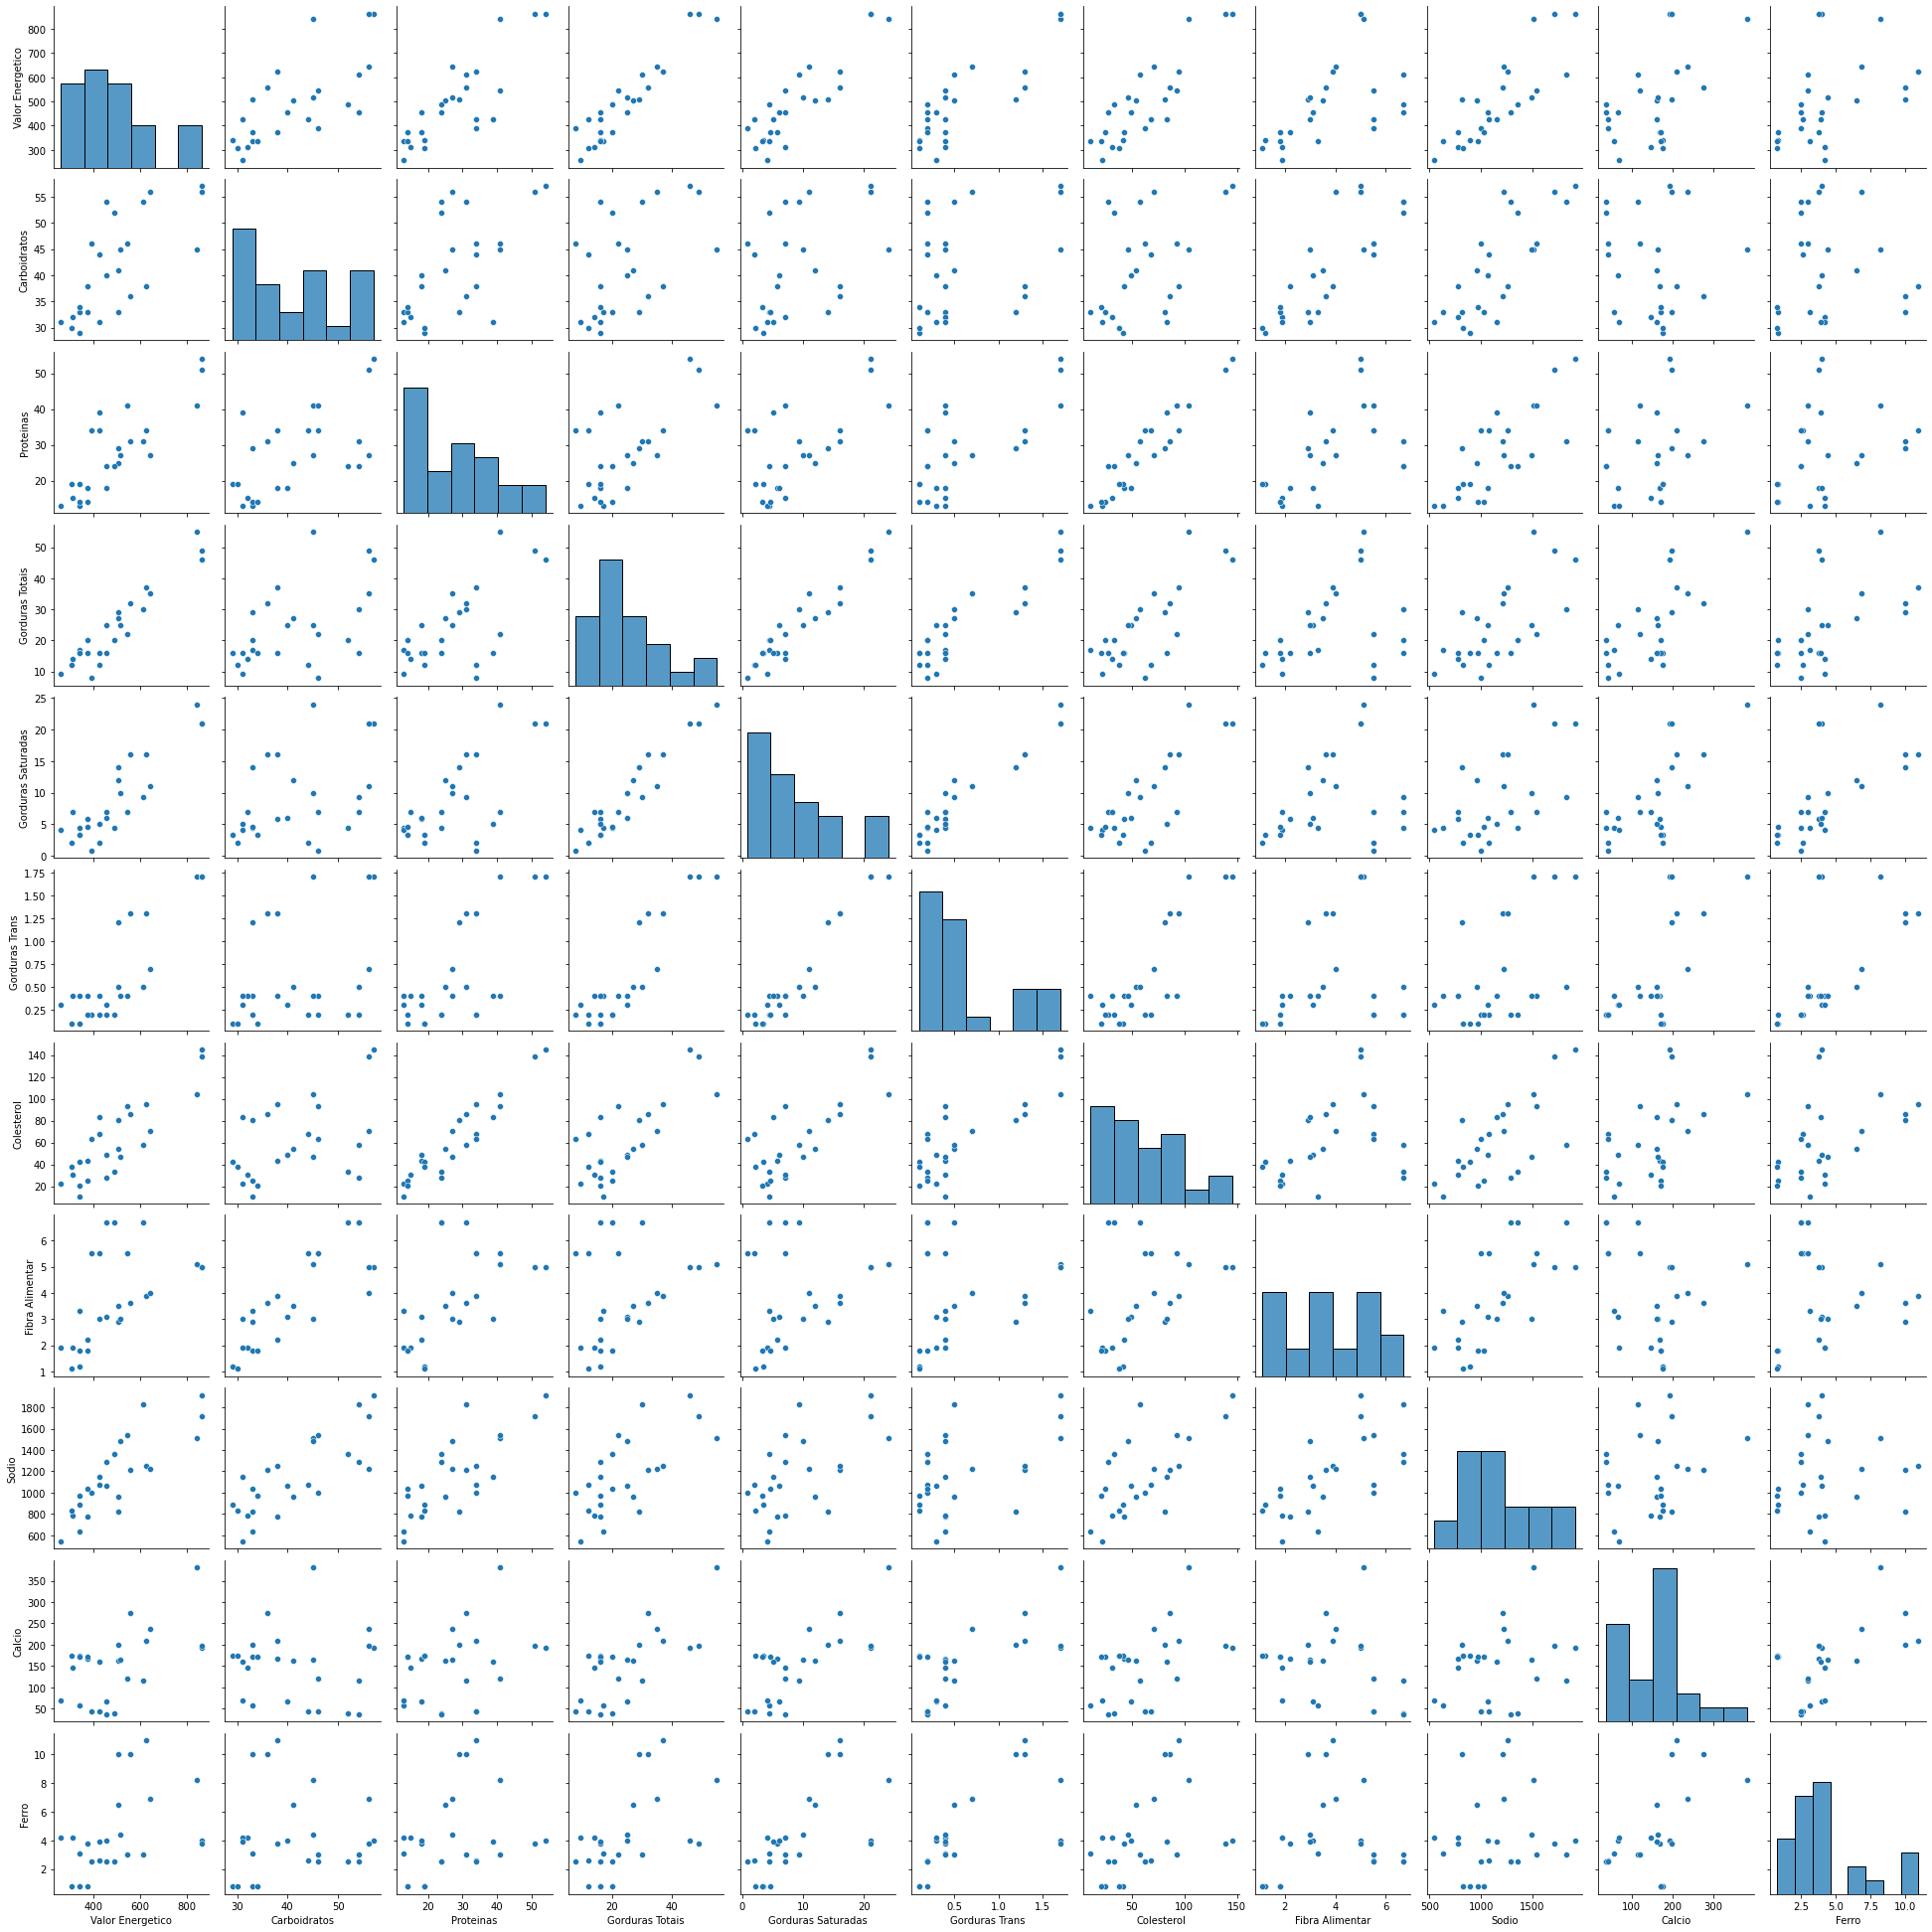

In [77]:
sns.pairplot(mcdonalds)

<AxesSubplot:>

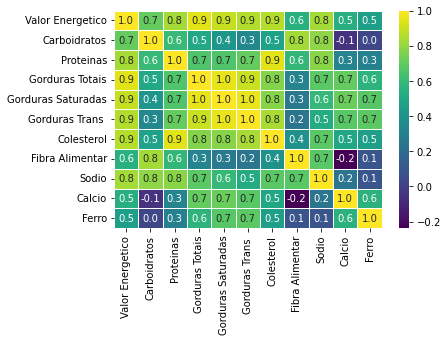

In [78]:
correlation = mcdonalds.corr()
sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6, cmap='viridis')

# Método do cotovelo

In [93]:
#Padronizar variaveis
scaler = MinMaxScaler()
mcdonalds_padronizado = scaler.fit_transform(mcdonalds)
mcdonalds_padronizado = pd.DataFrame(mcdonalds_padronizado, index=mcdonalds.index)

In [127]:
#Kmeans 
def clustering(mcdonalds_padronizado, k):
  kmeans = KMeans(n_clusters = k).fit(mcdonalds_padronizado)
  return kmeans.inertia_

In [129]:
#numero de clusters
n_clusters_candidatos = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
valores = []
for k in n_clusters_candidatos:
    valor = clustering(mcdonalds_padronizado, k)
    print(f'{k}: {valor}')
    valores.append(valor)

min_valor = np.inf
melhor_k = -1

for i in range(1, len(valores)-1):
    val1 = valores[i-1] - valores[i]
    val2 = valores[i] - valores[i+1]
    val = val2 / val1
    if val < min_valor:
        min_valor = val
        melhor_k = n_clusters_candidatos[i]

print("Melhor k: ", melhor_k) 

1: 21.769451880000126
2: 11.914823406180066
3: 7.840513434417575
4: 5.071350642940318
5: 4.044641348795993
6: 3.3764658412943973
7: 2.690712832697425
8: 2.223038968879317
9: 1.7838882271252277
10: 1.4088143632988128
Melhor k:  4


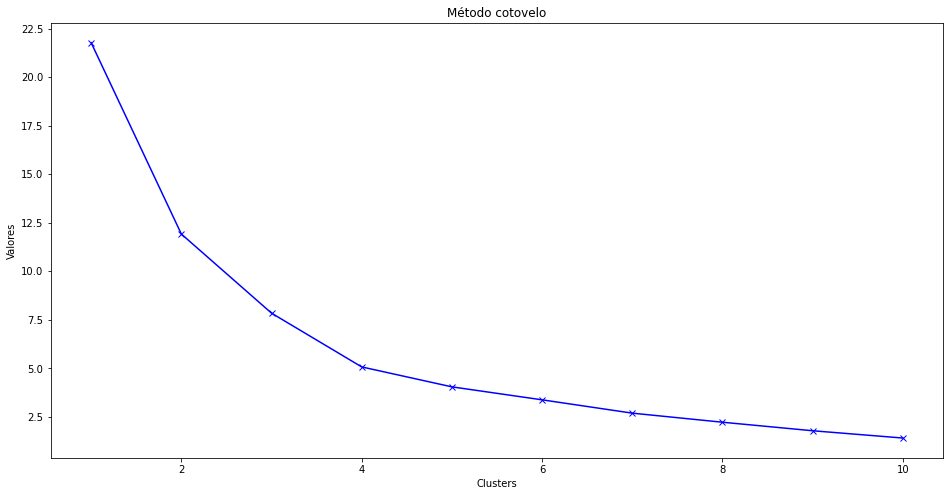

In [130]:
#Plotando o grafico do cotovelo

plt.figure(figsize=(16,8))
plt.plot(n_clusters_candidatos, valores, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Valores')
plt.title('Método cotovelo')
plt.show()

# Definição dos clusters

In [131]:
# Kmeans para o modelo
def cluster(n_clusters):
    modelo = KMeans(n_clusters=n_clusters)
    modelo.fit(mcdonalds_padronizado)
    Z = modelo.predict(mcdonalds_padronizado)
    return modelo, Z

In [136]:
#definição dos clusters
n_clusters = melhor_k
modelo, Z = cluster(n_clusters)
# Adição do cluster na planilha
mcdonalds['Cluster'] = Z

In [138]:
#plot dos hamburguers com eixo x valor energetico e eixo y gorduras totais
trace0 = pgo.Scatter(x=mcdonalds_padronizado[0],
                     y=mcdonalds_padronizado[3],
                     text=mcdonalds.index,
                     name='',
                     mode='markers',
                     marker=pgo.Marker(size=mcdonalds['Proteinas'],
                                       sizemode='diameter',
                                       sizeref=mcdonalds['Proteinas'].max()/50,
                                       opacity=0.5,
                                       color=Z),
                     showlegend=False)

/Users/daniellylima/opt/anaconda3/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




In [150]:
#plot dos centros dos clusters
trace1 = pgo.Scatter(x=modelo.cluster_centers_[:, 0],
                     y=modelo.cluster_centers_[:, 3],
                     name='',
                     mode='markers',
                     marker=pgo.Marker(symbol='x',
                                       size=12,
                                       color=('black')),
                    showlegend=False)

In [151]:
#layout do grafico
layout = pgo.Layout(title='K-means clustering com 4 clusters',
                     xaxis=pgo.XAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     yaxis=pgo.YAxis(showgrid=False,
                                     zeroline=False,
                                     showticklabels=False),
                     hovermode='closest')

In [152]:
#Grafico
data = pgo.Data([trace0, trace1])
layout['title'] = 'K-means clustering com 4 clusters'
fig = pgo.Figure(data=data, layout=layout)
fig